# Proyecto Redes Neuronales: Perceptrón Multicapa con Embeddings (PyTorch)

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo MLP con embeddings usando PyTorch (Entrega 1 - refactorización)  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## Componentes implementados:
1. Configuración de Parámetros Globales
2. Carga y Preprocesamiento de Datos con PyTorch
3. Tokenización y Vocabulario Personalizado
4. Construcción del Modelo MLP con Embedding en PyTorch
5. Entrenamiento con Early Stopping
6. Evaluación del Modelo
7. Visualización de Resultados
8. Guardado de Experimentos

## 0. Configuración de Parámetros Globales

In [1]:
# ===== CONFIGURACIÓN DE PARÁMETROS GLOBALES =====

# Configuración general del experimento
EXPERIMENT_NAME = "MLP_PyTorch_Embedding"
MODEL_TYPE = "MLP_Embedding_Torch"
RANDOM_SEED = 42
PROJECT_PART = "project_part_1"

# Directorios de trabajo
DATA_DIR = "data"
MODEL_DIR = f"models/{PROJECT_PART}"
OUTPUT_DIR = f"output/{PROJECT_PART}"

# Configuración del dataset
TEXT_COLUMN = "review_body"
TITLE_COLUMN = "review_title"
TARGET_COLUMN = "stars"
LANGUAGE_COLUMN = "language"
FILTER_LANGUAGE = "en"  # None para todos
USE_TITLE_AND_BODY = True

# Parámetros de tokenización y vocabulario
MAX_VOCAB_SIZE = 80000
MAX_LENGTH = 300
OOV_TOKEN = "<OOV>"
PAD_TOKEN = "<PAD>"

# Arquitectura del modelo
EMBEDDING_DIM = 300
HIDDEN_LAYERS = [256, 128, 64]
DROPOUT_RATE = 0.3

# Parámetros de entrenamiento
EPOCHS = 50
BATCH_SIZE = 512
LEARNING_RATE = 0.001
PATIENCE = 10

print(f"=== Configuración: {EXPERIMENT_NAME} ===")
print(f"Framework: PyTorch")
print(f"Proyecto: {PROJECT_PART}")
print(f"Idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Embedding: {EMBEDDING_DIM}d")
print(f"Max Length: {MAX_LENGTH}")
print(f"Arquitectura: {HIDDEN_LAYERS}")
print("="*60)

=== Configuración: MLP_PyTorch_Embedding ===
Framework: PyTorch
Proyecto: project_part_1
Idioma: en
Embedding: 300d
Max Length: 300
Arquitectura: [256, 128, 64]


## 1. Importación de Librerías

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import classification_report

# Importar helpers directamente desde sus módulos
from helpers.data_loader_torch import DataLoaderTorch
from helpers.model_trainer_torch import ModelTrainerTorch
from helpers.results_manager import ResultsManager
from helpers.visualizer import Visualizer
from helpers.models import MLPWithEmbedding
from helpers.utils import (
    setup_experiment_environment_torch,
    save_model_components_torch,
    evaluate_model_torch
)

# Configurar ambiente
gpu_info = setup_experiment_environment_torch(RANDOM_SEED)
print(f"GPU disponible: {gpu_info['gpu_available']}")
if gpu_info['gpu_available']:
    print(f"GPU: {gpu_info['gpu_names']}")
    print(f"CUDA: {gpu_info['cuda_version']}")

GPU configurada: 1 GPU(s) disponibles
Usando: NVIDIA GeForce RTX 5070
GPU disponible: True
GPU: ['NVIDIA GeForce RTX 5070']
CUDA: 13.0


## 2. Carga y Preprocesamiento de Datos

In [3]:
# Cargar datos
data_loader = DataLoaderTorch(data_dir=DATA_DIR)
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nDatos originales:")
print(f"Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

# Filtrar por idioma si se especifica
if FILTER_LANGUAGE and LANGUAGE_COLUMN in train_df.columns:
    print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
    train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
    print(f"Filtrados: Train: {len(train_df):,}, Val: {len(val_df):,}, Test: {len(test_df):,}")

# Distribución de clases
print(f"\nDistribución de clases:")
class_distribution = train_df[TARGET_COLUMN].value_counts().sort_index()
for stars, count in class_distribution.items():
    print(f"  {stars} estrellas: {count:,} ({count/len(train_df)*100:.1f}%)")

Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Datos originales:
Train: 1,200,000, Val: 30,000, Test: 30,000

Filtrando por idioma: en
Filtrados: Train: 200,000, Val: 5,000, Test: 5,000

Distribución de clases:
  1 estrellas: 40,000 (20.0%)
  2 estrellas: 40,000 (20.0%)
  3 estrellas: 40,000 (20.0%)
  4 estrellas: 40,000 (20.0%)
  5 estrellas: 40,000 (20.0%)


## 3. Preprocesamiento con Embeddings (PyTorch)

In [4]:
# Preprocesar datos con embeddings
print("\nPreprocesando con PyTorch (Embeddings)...")
processed = data_loader.preprocess_text_data_embedding(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_words=MAX_VOCAB_SIZE,
    max_length=MAX_LENGTH,
    use_title_and_body=USE_TITLE_AND_BODY,
    batch_size=BATCH_SIZE
)

# Extraer info
train_loader = processed['train_loader']
val_loader = processed['val_loader']
test_loader = processed['test_loader']
num_classes = processed['num_classes']
vocab_size = processed['vocab_size']

print(f"\nVocabulario: {vocab_size}")
print(f"Clases: {num_classes}")
print(f"Max Length: {MAX_LENGTH}")

class_names = [str(i) for i in data_loader.label_encoder.classes_]


Preprocesando con PyTorch (Embeddings)...
Preprocesando datos de texto...
Tamaño del vocabulario: 49069
Número de clases: 5
Longitud de secuencia: 300
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario: 49070
Clases: 5
Max Length: 300


## 4. Construcción del Modelo PyTorch con Embeddings

In [5]:
# Crear modelo
print("\nCreando modelo PyTorch con Embeddings...")
model = MLPWithEmbedding(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    padding_idx=0,
    use_masked_pooling=True  # Masked pooling enabled to ignore padding
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parámetros totales: {total_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")
print(f"Arquitectura: Embedding({EMBEDDING_DIM}) -> {HIDDEN_LAYERS}")
print(f"Masked pooling: False (igual que TF sin mask_zero)")


Creando modelo PyTorch con Embeddings...
Parámetros totales: 14,916,914
Parámetros entrenables: 14,916,914
Arquitectura: Embedding(300) -> [256, 128, 64]
Masked pooling: False (igual que TF sin mask_zero)


## 5. Configuración de Entrenamiento

In [6]:
# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=PATIENCE//2
)

print("\nConfiguración:")
print(f"Optimizador: Adam (lr={LEARNING_RATE})")
print(f"Loss: CrossEntropyLoss")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience={PATIENCE//2})")


Configuración:
Optimizador: Adam (lr=0.001)
Loss: CrossEntropyLoss
Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


## 6. Entrenamiento

In [7]:
# Entrenar
trainer = ModelTrainerTorch(model_dir=MODEL_DIR)

print("\nIniciando entrenamiento...")
training_results = trainer.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=f"{MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    scheduler=scheduler
)

print(f"\nEntrenamiento completado:")
print(f"Épocas: {training_results['epochs_trained']}")
print(f"Tiempo: {training_results['training_time']:.1f}s")
print(f"Mejor Val Acc: {training_results['best_val_accuracy']:.4f}")

# Guardar componentes
model_name = os.path.basename(training_results['model_path']).replace('.pth', '')
save_model_components_torch(
    model_name=model_name,
    model=model,
    vocab=data_loader.vocab,
    label_encoder=data_loader.label_encoder,
    model_dir=MODEL_DIR
)

Usando dispositivo: cuda

Iniciando entrenamiento...

Entrenando MLP_Embedding_Torch_20251128_122745...
Parámetros totales: 14,916,914
Parámetros entrenables: 14,916,914


Epoch 1/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 286.79it/s, loss=0.5553, acc=58.40%]



Epoch 1/50:
  Train Loss: 1.0625, Train Acc: 0.5454
  Val Loss: 0.9624, Val Acc: 0.5840
  Learning Rate: 0.001000
  ✓ Mejor modelo guardado (Val Loss: 0.9624)


Epoch 2/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 255.67it/s, loss=0.6182, acc=58.84%]



Epoch 2/50:
  Train Loss: 0.9013, Train Acc: 0.6253
  Val Loss: 0.9633, Val Acc: 0.5884
  Learning Rate: 0.001000
  Épocas sin mejora: 1/10


Epoch 3/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 257.37it/s, loss=0.7115, acc=58.34%]



Epoch 3/50:
  Train Loss: 0.8388, Train Acc: 0.6565
  Val Loss: 0.9980, Val Acc: 0.5834
  Learning Rate: 0.001000
  Épocas sin mejora: 2/10


Epoch 4/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 267.39it/s, loss=0.7037, acc=57.70%]



Epoch 4/50:
  Train Loss: 0.7862, Train Acc: 0.6794
  Val Loss: 1.0424, Val Acc: 0.5770
  Learning Rate: 0.001000
  Épocas sin mejora: 3/10


Epoch 5/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 261.97it/s, loss=0.8168, acc=57.70%]



Epoch 5/50:
  Train Loss: 0.7381, Train Acc: 0.6984
  Val Loss: 1.0964, Val Acc: 0.5770
  Learning Rate: 0.001000
  Épocas sin mejora: 4/10


Epoch 6/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 257.43it/s, loss=0.8998, acc=57.22%]



Epoch 6/50:
  Train Loss: 0.6906, Train Acc: 0.7161
  Val Loss: 1.1840, Val Acc: 0.5722
  Learning Rate: 0.001000
  Épocas sin mejora: 5/10


Epoch 7/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 264.45it/s, loss=0.8967, acc=57.00%]



Epoch 7/50:
  Train Loss: 0.6459, Train Acc: 0.7337
  Val Loss: 1.2481, Val Acc: 0.5700
  Learning Rate: 0.000500
  Épocas sin mejora: 6/10


Epoch 8/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 272.26it/s, loss=1.0780, acc=56.18%]



Epoch 8/50:
  Train Loss: 0.5678, Train Acc: 0.7665
  Val Loss: 1.4441, Val Acc: 0.5618
  Learning Rate: 0.000500
  Épocas sin mejora: 7/10


Epoch 9/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 270.24it/s, loss=1.1486, acc=56.00%]



Epoch 9/50:
  Train Loss: 0.5257, Train Acc: 0.7833
  Val Loss: 1.5544, Val Acc: 0.5600
  Learning Rate: 0.000500
  Épocas sin mejora: 8/10


Epoch 10/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 283.75it/s, loss=1.2484, acc=56.00%]



Epoch 10/50:
  Train Loss: 0.4945, Train Acc: 0.7975
  Val Loss: 1.6857, Val Acc: 0.5600
  Learning Rate: 0.000500
  Épocas sin mejora: 9/10


Epoch 11/50 [Val]: 100%|██████████| 10/10 [00:00<00:00, 264.38it/s, loss=1.3537, acc=55.66%]



Epoch 11/50:
  Train Loss: 0.4675, Train Acc: 0.8073
  Val Loss: 1.8177, Val Acc: 0.5566
  Learning Rate: 0.000500
  Épocas sin mejora: 10/10

Early stopping en época 11

Mejor modelo restaurado
Modelo guardado en: models/project_part_1/MLP_Embedding_Torch_20251128_122745.pth

Entrenamiento completado:
Épocas: 11
Tiempo: 33.4s
Mejor Val Acc: 0.5840
Modelo guardado: models/project_part_1/MLP_Embedding_Torch_20251128_122745.pth
Label encoder guardado: models/project_part_1/MLP_Embedding_Torch_20251128_122745_label_encoder.pkl
Componentes guardados en models/project_part_1/


## 7. Visualización

Gráfico de historial de entrenamiento guardado en: output/project_part_1/MLP_Embedding_Torch_training.png


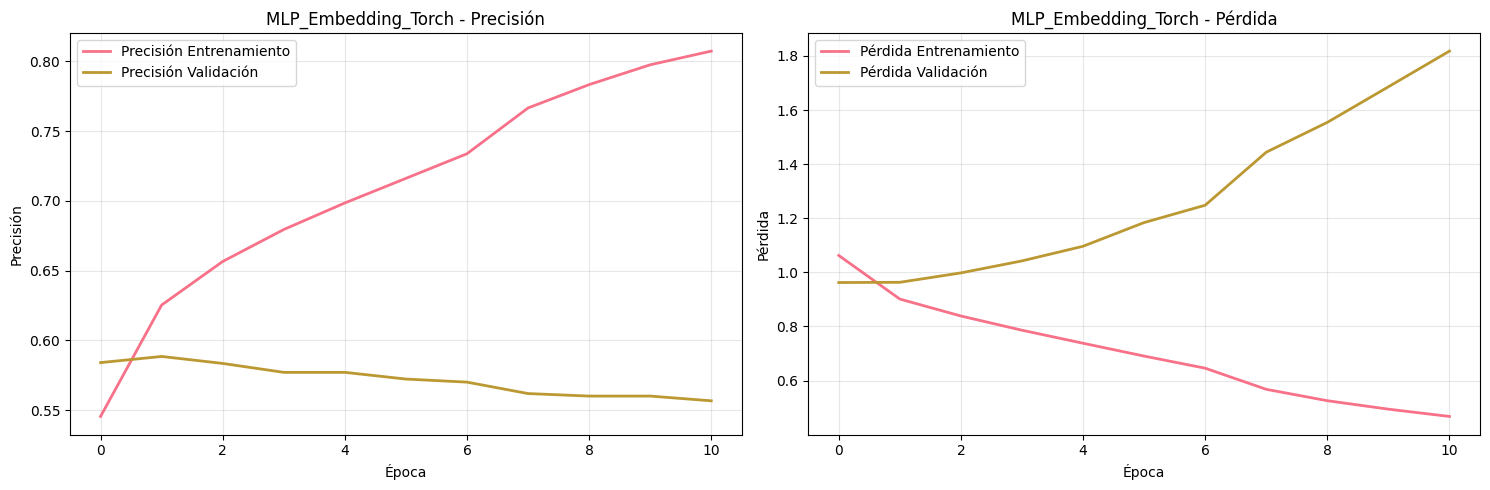

In [8]:
# Visualizar historial
Visualizer.plot_training_history(
    history=training_results['history'],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_training.png"),
    framework="pytorch"
)

## 8. Evaluación

In [9]:
# Evaluar
eval_results = evaluate_model_torch(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=trainer.device,
    class_names=class_names
)

test_accuracy = eval_results['test_accuracy']
test_loss = eval_results['test_loss']
y_true = eval_results['y_true']
y_pred = eval_results['y_pred']

classification_rep = classification_report(y_true, y_pred, 
                                          target_names=class_names, 
                                          output_dict=True)

print(f"\nResultados:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Loss: {test_loss:.4f}")
print(f"F1 (macro): {classification_rep['macro avg']['f1-score']:.4f}")

Evaluando modelo en datos de prueba...
Precisión de Prueba: 0.5564
Pérdida de Prueba: 1.8249

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.63      0.68      0.66      1000
           2       0.45      0.45      0.45      1000
           3       0.44      0.43      0.43      1000
           4       0.54      0.47      0.50      1000
           5       0.68      0.76      0.72      1000

    accuracy                           0.56      5000
   macro avg       0.55      0.56      0.55      5000
weighted avg       0.55      0.56      0.55      5000


Resultados:
Accuracy: 0.5564
Loss: 1.8249
F1 (macro): 0.5525


## 9. Matriz de Confusión

Matriz de confusión guardada en: output/project_part_1/MLP_Embedding_Torch_confusion.png


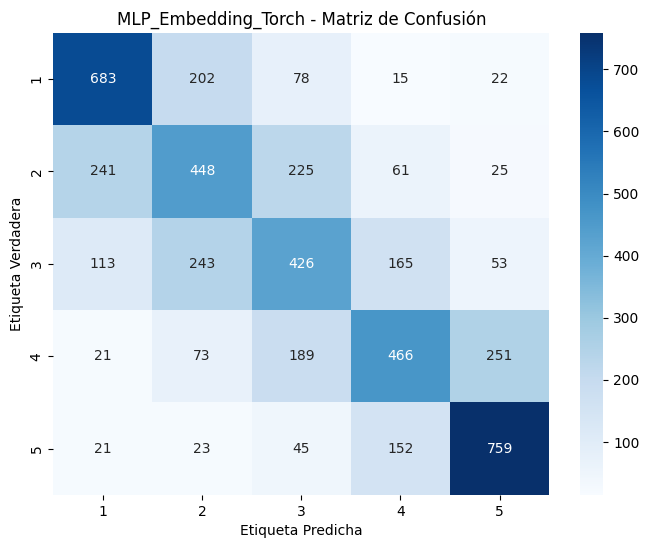

In [10]:
# Matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_confusion.png")
)

## 10. Guardar Experimento

In [11]:
# Preparar datos del experimento
experiment_data = {
    'experiment_name': EXPERIMENT_NAME,
    'configuration': {
        'model_type': MODEL_TYPE,
        'framework': 'pytorch',
        'language_filter': FILTER_LANGUAGE,
        'max_vocab_size': MAX_VOCAB_SIZE,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_layers': HIDDEN_LAYERS,
        'dropout_rate': DROPOUT_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'class_distribution': class_distribution.to_dict()
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar
results_mgr = ResultsManager(output_dir="output", project_part=PROJECT_PART)
experiment_id = results_mgr.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado")
print(f"Proyecto: {PROJECT_PART}")
print(f"Modelo: {training_results['model_path']}")

Experiment 10 results saved to output/project_part_1/experiment_history.json

Experimento #10 guardado
Proyecto: project_part_1
Modelo: models/project_part_1/MLP_Embedding_Torch_20251128_122745.pth


## 11. Resumen

In [12]:
# Resumen
print(f"\n{'='*60}")
print(f"RESUMEN - Experimento #{experiment_id}")
print(f"{'='*60}")
print(f"Framework: PyTorch")
print(f"Modelo: {MODEL_TYPE}")
print(f"Parámetros: {total_params:,}")
print(f"Embedding: {EMBEDDING_DIM}d, Vocab: {vocab_size}")
print(f"\nDatos: Train {len(train_df):,}, Val {len(val_df):,}, Test {len(test_df):,}")
print(f"\nResultados:")
print(f"  Test Acc: {test_accuracy:.4f}")
print(f"  F1 (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"\nHardware: {'GPU' if gpu_info['gpu_available'] else 'CPU'}")
print(f"{'='*60}")


RESUMEN - Experimento #10
Framework: PyTorch
Modelo: MLP_Embedding_Torch
Parámetros: 14,916,914
Embedding: 300d, Vocab: 49070

Datos: Train 200,000, Val 5,000, Test 5,000

Resultados:
  Test Acc: 0.5564
  F1 (macro): 0.5525

Hardware: GPU


## 12. Historial

In [13]:
# Ver historial
results_mgr.display_experiment_history()


HISTORIAL DE EXPERIMENTOS (10 experimentos)

ID  Modelo          Lang   Precisión  Pérdida    Épocas   Tiempo (s) Muestras  
-----------------------------------------------------------------------------------------------
1   MLP_BoW_Torch   en     0.5010     1.8052     12       28.7       200,000   
2   MLP_Embedding_  en     0.5432     2.2719     12       40.1       200,000   
3   MLP_Embedding_  en     0.5726     1.4026     12       31.9       200,000   
4   MLP_Embedding_  en     0.5538     1.7688     11       33.2       200,000   
5   MLP_Embedding_  en     0.5566     1.8177     11       32.6       200,000   
6   MLP_Embedding_  en     0.5606     1.5685     13       35.8       200,000   
7   MLP_Embedding_  en     0.5760     1.1913     12       33.1       200,000   
8   MLP_Embedding_  en     0.5594     1.3719     19       54.7       200,000   
9   MLP_Embedding_  en     0.5736     1.1775     12       32.7       200,000   
10  MLP_Embedding_  en     0.5566     1.8177     11       